# Thermal Hazard Detection and Prediction Model
## Querying of Dataset

In [92]:
%reset -f

import sys
import pandas as pd
import numpy as np
from query_tool import M100DataClient
from matplotlib import pyplot as plt
import datetime

dataset_path = 'dataset'
client = M100DataClient(dataset_path)

df = client.query('ambient',
                  columns=['timestamp','node','value'],
                  year_month=['21-05','21-06','21-07','21-08']) 




Retrieving data of type: float


## Preprocessing

In [93]:
### Pivot 
print(f'Shape of the original dataset is: {df.shape}.')
df = df.pivot(index='timestamp', columns='node', values='value')
print(f'Shape of dataset after pivoting is {df.shape}.')

### Resampling
sampling_fre_m = 10
df = df.resample(str(sampling_fre_m)+'T').mean()
print(f'Shape of dataset after resmapling with  frequency of 10 minute is {df.shape}.')
df.sort_index(inplace=True)

Shape of the original dataset is: (510008441, 3).
Shape of dataset after pivoting is (522188, 979).
Shape of dataset after resmapling with  frequency of 10 minute is (17712, 979).


### Missing Data

 In total 0.57% data are missed.


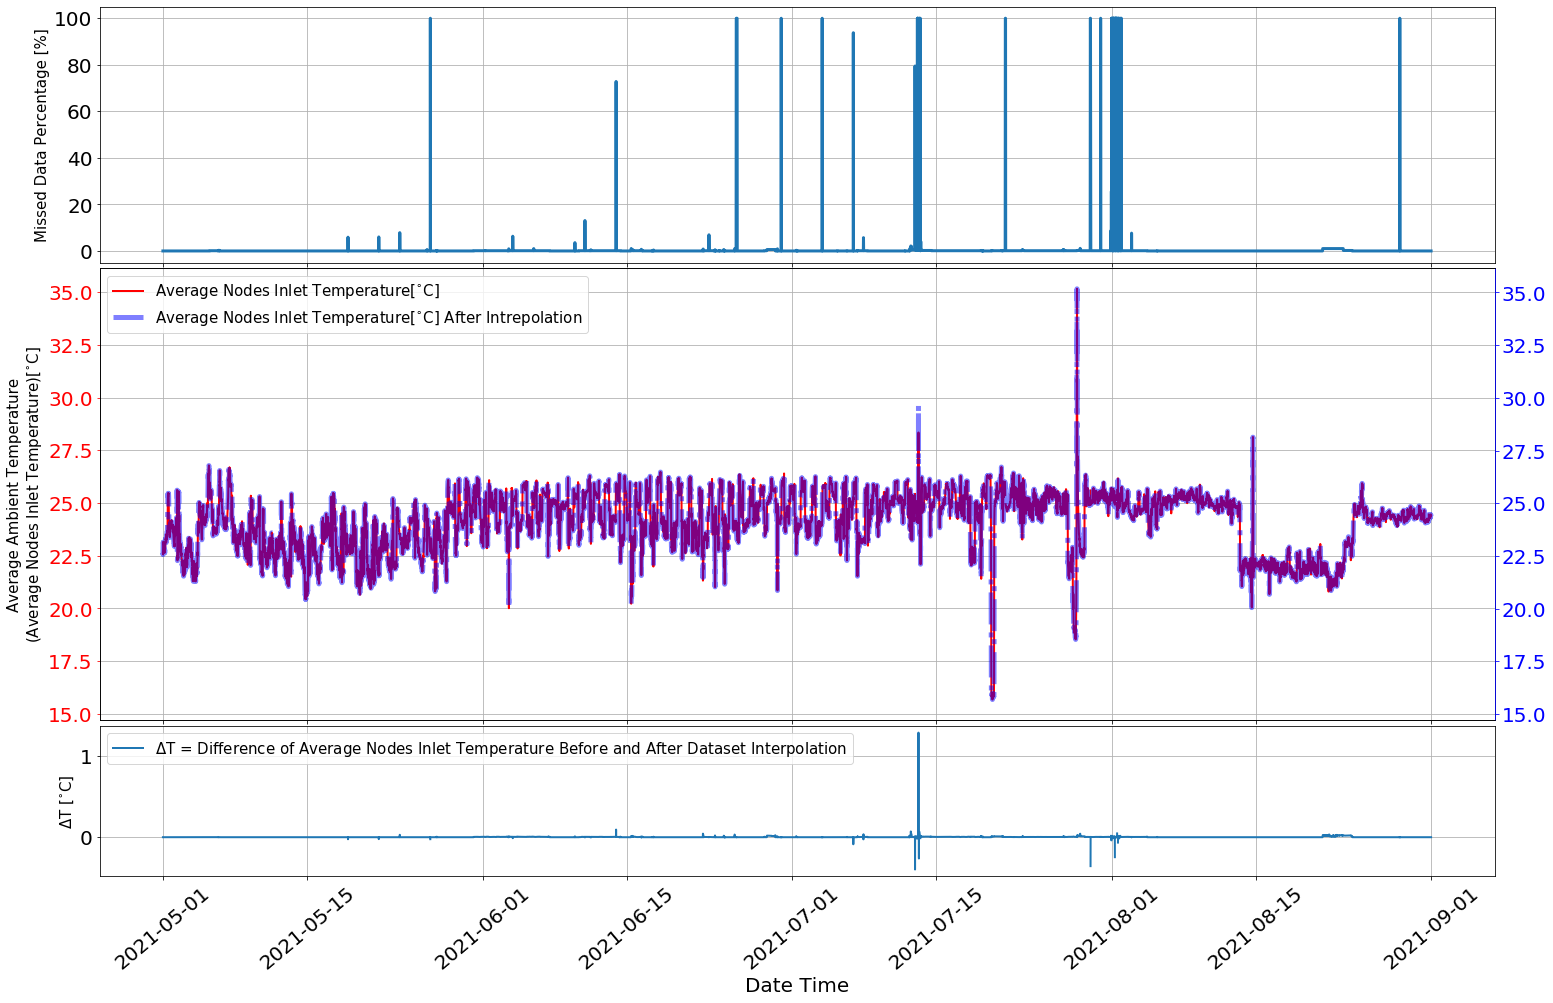

In [141]:
print(f' In total {np.round(100*df.isnull().sum().sum()/(df.shape[0]*df.shape[1]),2)}% data are missed.')


df_intp = df.interpolate(axis=1).interpolate(axis=0)

fig, axl = plt.subplots(3,1, figsize=(25,16), sharex=True, gridspec_kw={'height_ratios': [0.17, 0.3, 0.1]})

axr = axl[1].twinx()



axl[0].plot((100*df.isnull().sum(axis=1)/len(df.columns)), lw=3)




lns1 = axl[1].plot(df.mean(axis=1), lw=2, color='r',alpha=1, label='Average Nodes Inlet Temperature[$^{\circ}$C]')
lns2 = axr.plot(df_intp.mean(axis=1), lw=5, color='b',alpha=0.5, linestyle='dashdot', label='Average Nodes Inlet Temperature[$^{\circ}$C] After Intrepolation')

axl[2].plot(df_intp.mean(axis=1)-df.mean(axis=1), lw=2, 
                   label='$\Delta$T = Difference of Average Nodes Inlet Temperature Before and After Dataset Interpolation')


axl[0].tick_params(axis='y', which='major', labelsize=20)
axl[1].tick_params(axis='y', which='major', labelsize=20, rotation=0, colors='r')
axl[2].tick_params(axis='y', which='major', labelsize=20, rotation=0)
axr.tick_params(axis='y', which='major', labelsize=20, rotation=0, colors='b')
axl[2].tick_params(axis='x', which='major', labelsize=20, rotation=40)




axl[0].set_ylabel('Missed Data Percentage [%]', fontsize=15)
axl[1].set_ylabel('Average Ambient Temperature\n(Average Nodes Inlet Temperature)[$^{\circ}$C]', fontsize=15)
axl[2].set_ylabel('$\Delta$T [$^{\circ}$C]', fontsize=15)
axl[2].set_xlabel('Date Time', fontsize=20)

axr.spines['right'].set_color('b')

for i in range(3):
    axl[i].grid()





lns = lns1+lns2
labs = [l.get_label() for l in lns]
axl[1].legend(lns, labs, loc=0, fontsize=15)
axl[2].legend(loc=0, fontsize=15)
plt.subplots_adjust(wspace=0, hspace=0.02)

plt.show()

## Dataset Annotation 

'The shape dataset is (17712, 979).'

'The room label coefficient is 1762.'

,rowSum
timestamp,
2021-05-01 00:00:00+00:00,0
2021-05-01 00:10:00+00:00,0
2021-05-01 00:20:00+00:00,0
2021-05-01 00:30:00+00:00,1
2021-05-01 00:40:00+00:00,7
...,...
2021-08-31 23:10:00+00:00,0
2021-08-31 23:20:00+00:00,0
2021-08-31 23:30:00+00:00,0


,rowSum,room_label
timestamp,,
2021-05-01 00:00:00+00:00,0,0
2021-05-01 00:10:00+00:00,0,0
2021-05-01 00:20:00+00:00,0,0
2021-05-01 00:30:00+00:00,1,0
2021-05-01 00:40:00+00:00,7,0
...,...,...
2021-08-31 23:10:00+00:00,0,0
2021-08-31 23:20:00+00:00,0,0
2021-08-31 23:30:00+00:00,0,0


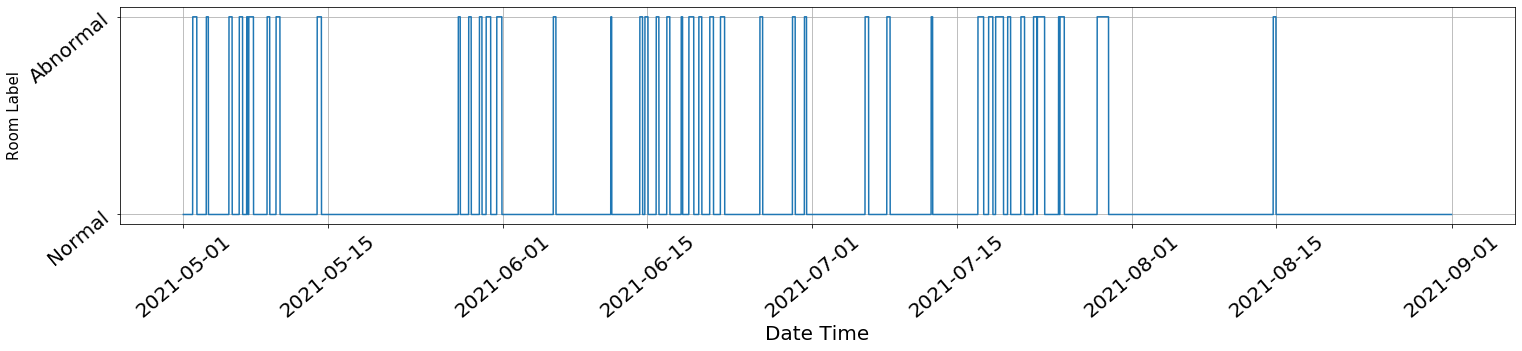

In [140]:
class label_gene:
    def __init__(self, 
                 sampling_freq_m, # sampling ferquency by [minutes] unit 
                 TW, # time window by [time delta] unit  
                 dataset_pvt, # Pandas DataFrame
                 Node_Threshold,
                 Spatial_Temporal_Impact_Threshold,
                 detection_prediction,
                 dsply = False):
        
        
        self.dataset_pvt = dataset_pvt
        self.sampling_freq_m = sampling_freq_m 
        self.TW = TW 
        self.TW_num = int(self.TW/datetime.timedelta(minutes=self.sampling_freq_m))
        assert self.TW_num == self.TW/datetime.timedelta(minutes=self.sampling_freq_m), 'TW divided by sampling_freq_m is not an integer. These two numbers should be divisible.'
        self.Node_Threshold = Node_Threshold 
        self.Spatial_Temporal_Impact_Threshold = Spatial_Temporal_Impact_Threshold 
        self.detection_prediction = detection_prediction
        self.dsply = dsply
        if self.dsply: display(f'The shape dataset is {self.dataset_pvt.shape}.')
        self.nodes_num = dataset_pvt.shape[1]
        self.room_lbe_cf = int(self.nodes_num * self.TW_num * self.Spatial_Temporal_Impact_Threshold)        
        if self.dsply: display(f'The room label coefficient is {self.room_lbe_cf}.')
        
        
        self.trfls_tbl = self.trfls_tbl()
        
        self.lbl_df = pd.DataFrame(self.trfls_tbl.sum(axis=1), columns=['rowSum'])
        
        
     
    def trfls_tbl(self): 
        # 'Cooling Aware'
        qntl = self.dataset_pvt.quantile(q=self.Node_Threshold, axis=0)
        trfls = self.dataset_pvt > pd.Series(qntl) # Create True False Matrix
        return trfls   
    
    
    
        
    def roomSum_detection(self,row):
        return self.lbl_df.loc[row.name-self.TW:row.name,'rowSum'].sum() 

    def roomSum_prediction(self,row):
        return self.lbl_df.loc[row.name:row.name+self.TW,'rowSum'].sum()  
    
    
    def thermal_hazard_label_gene(self):
        if self.detection_prediction == 'detection':
            self.lbl_df['room_label'] = self.lbl_df.apply(lambda row:1 if self.roomSum_detection(row) > self.room_lbe_cf else 0, axis=1)
            return self.lbl_df 
        elif self.detection_prediction == 'prediction':
            self.lbl_df['room_label'] = self.lbl_df.apply(lambda row:1 if self.roomSum_prediction(row) > self.room_lbe_cf else 0, axis=1)
            return self.lbl_df
        else:
            sys.exit('The detection_prediction variable can be either detection or prediction.')
         
            
   
   
    
    

lbl_gn = label_gene(sampling_freq_m=10,
                      TW=datetime.timedelta(hours=6), 
                      dataset_pvt=df_intp,
                      detection_prediction='detection',
                      Node_Threshold=0.98,
                      Spatial_Temporal_Impact_Threshold=0.05, 
                      dsply=True)


display(lbl_gn.lbl_df)
display(lbl_gn.thermal_hazard_label_gene())
lbl = lbl_gn.thermal_hazard_label_gene()

fig, ax = plt.subplots(1,1, figsize=(25,4))
ax.plot(lbl.room_label)
ax.tick_params(axis='both', which='major', labelsize=20,rotation=40)
ax.set_xlabel('Date Time', fontsize=20)
ax.set_yticks(ticks=[0,1])
ax.set_yticklabels(['Normal','Abnormal'])
ax.set_ylabel('Room Label', fontsize=20)
ax.grid()
plt.show()

## Machin Learning Model 
### Test Train Split

In [123]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_intp.values, lbl.room_label.values, test_size=0.2, random_state=5)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14169, 979) (3543, 979) (14169,) (3543,)


### Data Standardization

In [124]:
# Sklearn Std
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled_data = scaler.transform(X_train)
X_test_scaled_data = scaler.transform(X_test)

display(X_train_scaled_data.shape,X_test_scaled_data.shape)

(14169, 979)

(3543, 979)

### Support Vector Machines

In [125]:
from sklearn import svm
from sklearn import metrics

classifier = svm.SVC()
classifier.fit(X_train_scaled_data, y_train)
y_predict = classifier.predict(X_test_scaled_data)



print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3109
           1       0.88      0.65      0.75       434

    accuracy                           0.95      3543
   macro avg       0.92      0.82      0.86      3543
weighted avg       0.94      0.95      0.94      3543

